In [1]:
import os
import sys
import json

import pandas as pd
import torch
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm

In [4]:
from src.graph_construction import graph

In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
results_dir = os.path.join('results', 'e5')

In [7]:
with open(os.path.join(results_dir, 'config.txt'), 'r') as file:
    config = json.load(file)

In [8]:
config

{'custom_optimizer': "<class 'torch.optim.adam.Adam'>",
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'graph_outchannels': 4,
 'graph_layers': 1,
 'graph_heads': 6,
 'test-percent': 15,
 'building_buffer': 100,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 600,
 'input_shape': 3}

In [9]:
config['building_buffer'] = 20

In [10]:
g1, g1a = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

# nycgraph = transform(nycgraph)

In [21]:
g1a['footprints'].drop(columns=["id","geometry","year"]).describe()

,energy,area,amplitude,bias,hdd,cdd
count,1.323400e+04,13234.000000,13234.000000,13234.000000,13234.000000,13234.000000
mean,1.714493e+04,12302.970213,17.754482,21.351632,2792.341399,4775.363586
std,3.676281e+05,18832.138846,1.264326,1.572516,571.044566,569.773269
min,3.597384e-01,46.823177,10.650592,15.892588,185.345664,2314.126614
25%,1.062512e+03,4264.183985,16.966367,20.244481,2480.817945,4410.039110
50%,1.714635e+03,6711.786620,17.919956,21.226105,2925.920645,4779.014330
75%,3.066965e+03,12310.872453,18.696789,22.299809,3187.816579,5151.012169
max,2.633561e+07,337859.233178,21.563701,27.129769,4149.092892,7351.370592


In [13]:
g2, g2a = graph(
    "san-fransisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

In [22]:
g2a['footprints'].drop(columns=["id","geometry","year"]).describe()

,energy,area,amplitude,bias,hdd,cdd
count,1366.000000,1366.000000,1366.000000,1366.000000,1366.000000,1366.000000
mean,2090.699076,11828.848631,11.031249,29.247642,40.965477,7211.665974
std,3956.109555,18799.841512,0.818182,1.512787,78.179159,935.498905
min,5.379747,743.224000,8.668190,25.247232,0.000000,4850.312246
25%,271.435621,2233.016508,10.423817,28.472724,0.000000,6705.000589
50%,784.970996,5293.334231,11.047536,29.298760,0.000000,7214.431116
75%,2027.546029,12423.221417,11.610795,30.302908,41.632817,7866.649877
max,38793.723026,182484.717750,13.292611,32.685806,426.474943,9429.574551


In [15]:
g3, g3a = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

In [23]:
g3a['footprints'].drop(columns=["id","geometry","year"]).describe()

,energy,area,amplitude,bias,hdd,cdd
count,62.000000,62.000000,62.000000,62.000000,62.0,62.000000
mean,124.663097,1301.197920,4.378237,33.959031,0.0,10266.083487
std,147.219323,1375.650750,10.595331,1.386153,0.0,910.702691
min,17.054730,205.501436,-13.035847,30.016816,0.0,7676.048124
25%,46.344783,557.418000,-9.930664,32.919782,0.0,9583.296872
50%,83.783215,868.224986,11.231498,34.178864,0.0,10410.513656
75%,135.909263,1476.228670,12.012714,35.013181,0.0,10958.660128
max,903.671250,8001.270875,13.201974,36.622950,0.0,12016.278251


In [16]:
g1['footprint'].train_mask.shape

torch.Size([13234])

In [48]:
### first thinking about new york

In [49]:
from statsmodels.api import OLS

In [187]:
from torch_scatter import scatter_mean, scatter_max, scatter_min

In [51]:
device = 'cuda:0'

In [52]:
g1a['node_data'].columns

Index(['sky_area', 'vegetation_area', 'car_count'], dtype='object')

In [198]:
def pool_adjacency(graph, graph_auxillary):
    """Pools environmental features from the region for their use with regression"""
    energy = scatter_mean(graph['footprint'].y, torch.tensor(graph_auxillary['rebuild_idx']).to(device))
    links = graph['footprint','contains','pano']['edge_index']
    features = scatter_mean(graph['pano'].x[links[1]], links[0], dim=0).detach().cpu().numpy()
    features_max = scatter_max(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    features_min = scatter_min(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    
    featurenames = graph_auxillary['node_data'].columns
    featuremin = featurenames + '_min'
    featuremax = featurenames + '_max'
    
    featuresdf = pd.DataFrame(features, columns = featurenames)
    featuresdfmax = pd.DataFrame(features_max, columns = featuremax)
    featuresdfmin = pd.DataFrame(features_min, columns = featuremin)
    return graph_auxillary['footprints'].join(featuresdf).join(featuresdfmax).join(featuresdfmin)

In [199]:
### 
g1p = pool_adjacency(g1, g1a)
g1p.loc[g1p.id.isin(train_buildings)].drop(columns=["id","geometry","year"])

,energy,area,amplitude,bias,sky_area,vegetation_area,car_count,sky_area_max,vegetation_area_max,car_count_max,sky_area_min,vegetation_area_min,car_count_min
0,906.882019,4982.209051,15.663097,24.023925,0.119573,0.040445,18.648148,0.22662,0.42077,35.0,0.0,0.0,2.0
1,6689.282660,43664.471056,16.164429,23.252700,0.165028,0.034143,19.799999,0.28038,0.42077,36.0,0.0,0.0,9.0
2,2222.101317,11313.278644,15.649305,24.053035,0.153871,0.029516,20.975609,0.28038,0.42077,36.0,0.0,0.0,11.0
3,981.997076,3809.028326,16.187118,23.040648,0.158572,0.068487,22.253969,0.28505,0.42077,40.0,0.0,0.0,11.0
4,829.060885,6049.108594,15.331565,24.336092,0.113645,0.066775,20.545454,0.28505,0.42077,40.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13812,2611.396917,13712.501974,19.011393,22.398537,0.224939,0.138621,10.303030,0.41083,0.44810,18.0,0.0,0.0,5.0
13813,1242.293042,2015.997919,15.076598,17.178491,0.114980,0.104000,5.701299,0.33462,0.55047,34.0,0.0,0.0,0.0
13814,4012.230753,12485.809047,19.497986,22.030902,0.283914,0.034336,13.080000,0.41025,0.21658,25.0,0.0,0.0,5.0
13816,639.843690,1323.869601,18.112908,21.970449,0.276885,0.094009,13.000000,0.40332,0.32424,23.0,0.0,0.0,4.0


In [200]:
test_buildings = g1p.loc[g1a['test_mask'].detach().cpu().numpy()].id
train_buildings = g1p.loc[~g1a['test_mask'].detach().cpu().numpy()].id

In [224]:
torch.exp

<function torch._VariableFunctionsClass.exp>

In [232]:
e1 = torch.nn.MSELoss()
def e2(ypred, y):
    return 100 * torch.abs(ypred - y) / y

In [233]:
def regress_distances(features_df, traintest):
    """Trains a small linear model on the data and predicts it against a test set"""
    train, test = traintest
    training_data = features_df.loc[features_df.id.isin(train)]
    testing_data = features_df.loc[features_df.id.isin(test)]
    
    training_x = training_data.drop(columns=["energy","id","geometry","year"])
    training_y = training_data["energy"]
    
    model = sm.OLS(training_y,training_x).fit()
    
    testing_x = testing_data.drop(columns=["energy","id","geometry","year"])
    testing_y = torch.tensor(np.array(testing_data["energy"])).to(device).squeeze()
        
    yhat = torch.tensor(np.array(model.predict(testing_x))).to(device).squeeze()
    
    return e1(yhat, testing_y), torch.mean(e2(yhat, testing_y))

In [234]:
np.linspace(20,100,10)

array([ 20.        ,  28.88888889,  37.77777778,  46.66666667,
        55.55555556,  64.44444444,  73.33333333,  82.22222222,
        91.11111111, 100.        ])

In [235]:
from tqdm import tqdm_notebook

In [239]:
mse_errors = []
acc_terms = []

buffer_distances = np.linspace(20,1500,100)

for i in tqdm_notebook(buffer_distances):
    config['building_buffer'] = i
    g1, g1a = graph(
        "new-york",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=config['building_buffer'],
        test_percent=config['test-percent']
    )
    g1p = pool_adjacency(g1, g1a)
    mse, acc = regress_distances(g1p, (train_buildings, test_buildings))
    mse_errors.append(mse)
    acc_terms.append(acc)

/tmp/ipykernel_9528/3990440859.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(buffer_distances):


  0%|          | 0/100 [00:00<?, ?it/s]

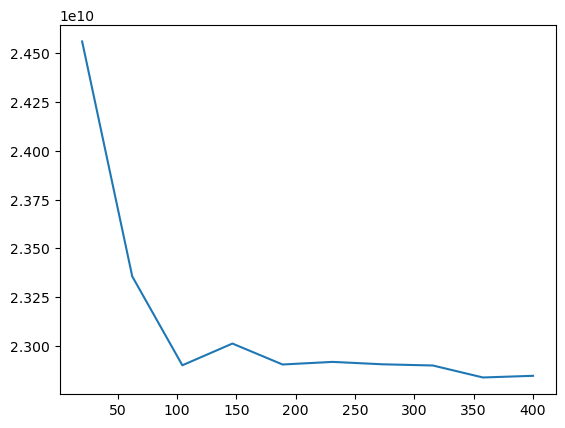

In [237]:
plt.plot(buffer_distances, torch.tensor(mse_errors).detach().cpu().numpy())

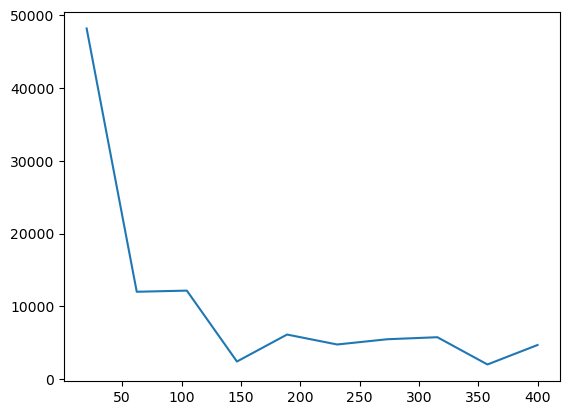

In [238]:
plt.plot(buffer_distances, torch.tensor(acc_terms).detach().cpu().numpy())
# plt.yscale('log')

In [77]:
g1a['training_mask'].shape

torch.Size([13234])

In [72]:
g1mask = g1a['training_mask'].detach().cpu().numpy()

In [82]:
Y = regmat['energy'].iloc[g1mask]
X = regmat.drop(columns='energy').iloc[g1mask]

In [83]:
model = sm.OLS(Y,X)
results = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and id                  object
area               float64
amplitude          float64
bias               float64
sky_area           float32
vegetation_area    float32
car_count          float32
dtype: object. The data was
0        9.068820e+02
1        7.956888e+03
2        1.122939e+06
3        1.210884e+03
4        5.310140e+02
             ...     
13227    7.395839e+03
13229    1.382376e+03
13230    5.723913e+03
13231    1.007693e+03
13232    2.981949e+02
Name: energy, Length: 11249, dtype: float64
and
                          id          area  amplitude       bias  sky_area  \
0       9831628575705046469   4982.209051  15.663097  24.023925  0.118824   
1      10426804091157841868  43841.823131  15.669831  24.047635  0.136401   
2      13984590206613124140   7460.121331  16.895919  21.118592  0.072026   
3       1578338801975438769   7483.068405  16.834552  21.090436  0.021487   
4      18069133829578216584   9754.828640  17.073126  21.101297  0.060022   
...                     ...           ...        ...        ...       ...   
13227   1836429563859990194  32198.180957  16.894077  22.159046  0.384654   
13229  12618438599830320340   8915.263055  18.925129  25.664360  0.298532   
13230   5493187043257100533  25350.105445  19.152906  21.454352  0.205083   
13231  15242956676492688919   1207.740689  15.917390  18.136740  0.150425   
13232   7395414680666969706   3496.688003  17.810793  22.104066  0.268572   

       vegetation_area  car_count  
0             0.086642  22.799999  
1             0.015655  18.000000  
2             0.000000  17.799999  
3             0.183797  22.000000  
4             0.040192  19.000000  
...                ...        ...  
13227         0.007456   3.600000  
13229         0.036943   9.250000  
13230         0.063285  16.750000  
13231         0.227303   8.250000  
13232         0.116989  18.571428  

[11249 rows x 7 columns]
before. After,
[9.06882019e+02 7.95688830e+03 1.12293892e+06 ... 5.72391283e+03
 1.00769331e+03 2.98194928e+02]
[['9831628575705046469' 4982.209050622916 15.66309674138622 ...
  0.11882400512695312 0.08664200454950333 22.799999237060547]
 ['10426804091157841868' 43841.82313102129 15.669830506338506 ...
  0.13640090823173523 0.015655454248189926 18.0]
 ['13984590206613124140' 7460.121331487658 16.895919365707062 ...
  0.07202599942684174 0.0 17.799999237060547]
 ...
 ['5493187043257100533' 25350.10544505245 19.15290625934775 ...
  0.205082505941391 0.06328500062227249 16.75]
 ['15242956676492688919' 1207.7406887838051 15.917389946902022 ...
  0.150424987077713 0.22730250656604767 8.25]
 ['7395414680666969706' 3496.688003418836 17.81079273442344 ...
  0.2685721218585968 0.11698929220438004 18.571428298950195]].

In [84]:
model.predict(regmat.drop(columns='energy').iloc[~g1mask])

NameError: name 'model' is not defined

In [85]:
results.summary()

NameError: name 'results' is not defined

In [56]:
g1_energy = scatter_mean(g1['footprint'].y, torch.tensor(g1a['rebuild_idx']).to(device)).detach().cpu().numpy()

In [76]:
g1_links = g1['footprint','contains','pano']['edge_index']

In [80]:
g1_links[0].shape

torch.Size([716642])

In [85]:
g1_features = scatter_mean(g1['pano'].x[g1_links[1]], g1_links[0], dim=0)

In [92]:
g1_df = pd.DataFrame(g1_features.detach().cpu().numpy(), columns = g1a['node_data'].columns)

In [96]:
g1a['footprints'].join(g1_df)

,id,geometry,year,energy,area,amplitude,bias,sky_area,vegetation_area,car_count
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",2012,906.882019,4982.209051,15.663097,24.023925,0.119573,0.040445,18.648148
1,6938448636445649773,"POLYGON ((586052.537 4510976.454, 586012.795 4...",2016,6689.282660,43664.471056,16.164429,23.252700,0.165028,0.034143,19.799999
2,9906335732894406041,"POLYGON ((585979.951 4510960.203, 585958.745 4...",2016,2222.101317,11313.278644,15.649305,24.053035,0.153871,0.029516,20.975609
3,14545201850494639820,"POLYGON ((586039.515 4510843.134, 586016.548 4...",2017,981.997076,3809.028326,16.187118,23.040648,0.158572,0.068487,22.253969
4,2515340659876366563,"POLYGON ((585906.529 4510882.449, 585893.280 4...",2012,829.060885,6049.108594,15.331565,24.336092,0.113645,0.066775,20.545454
...,...,...,...,...,...,...,...,...,...,...
13813,3162522797862880947,"POLYGON ((587289.030 4515245.943, 587207.798 4...",2016,1242.293042,2015.997919,15.076598,17.178491,0.114980,0.104000,5.701299
13814,2309459729724129729,"POLYGON ((595643.225 4511095.438, 595625.778 4...",2016,4012.230753,12485.809047,19.497986,22.030902,0.283914,0.034336,13.080000
13815,3010589633849135112,"POLYGON ((586796.159 4509068.953, 586792.590 4...",2012,4478.931430,8953.353338,17.717575,22.682001,0.367321,0.006043,10.551724
13816,5418421121047772298,"POLYGON ((592755.083 4508579.412, 592751.726 4...",2017,639.843690,1323.869601,18.112908,21.970449,0.276885,0.094009,13.000000


In [61]:
g1['pano'].x

HeteroData(
  pano={ x=[101465, 3] },
  footprint={
    x=[13818, 3],
    y=[30496],
    train_mask=[13818],
    test_mask=[13818]
  },
  (footprint, contains, pano)={ edge_index=[2, 716642] },
  (pano, links, pano)={ edge_index=[2, 4752385] },
  (pano, rev_contains, footprint)={ edge_index=[2, 716642] }
)

In [59]:
g1_features = 

array([6.9132867, 8.761321 , 7.810137 , ..., 8.322299 , 6.243939 ,
       6.6226788], dtype=float32)

In [41]:
np.array(g1a['rebuild_idx'])

array([    0,     0,     0, ..., 13816, 13817, 13817])

In [36]:
g1['footprint'].x

HeteroData(
  pano={ x=[101465, 3] },
  footprint={
    x=[13818, 3],
    y=[30496],
    train_mask=[13818],
    test_mask=[13818]
  },
  (footprint, contains, pano)={ edge_index=[2, 716642] },
  (pano, links, pano)={ edge_index=[2, 4752385] },
  (pano, rev_contains, footprint)={ edge_index=[2, 716642] }
)

In [ ]:
OLS(dataset.target,dataset.data).fit().summary()

In [30]:
g1['footprint'].x.shape

torch.Size([13818, 3])